In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import PercentFormatter

## Cancer Simulator

In [ ]:
################ Cancer Simulator ####################

#code from:
#Omer Gottesman, Joseph Futoma, Yao Liu, Sonali Parbhoo, Leo Celi, Emma Brunskill,
#and Finale Doshi-Velez. Interpretable off-policy evaluation in reinforcement learning by
#highlighting influential transitions. In International Conference on Machine Learning,
#pages 3658–3667. PMLR, 2020.

# This cancer simulator is built on the paper
#   * Ribba 2012 (https://pubmed.ncbi.nlm.nih.gov/22761472/)
#   * Yauney 2018 (http://proceedings.mlr.press/v85/yauney18a/yauney18a.pdf)

# The simulator approximate the dynamics of tumor growth, with actions consisting administration of chemotherapy TMZ at each timestep representing one month.

# * State space: 4-dimensional where the first dimension associates with drug concerntration and the last three with tumor diameter
# * Action space: TODO
# * Maximum Treatment cycle: 30


class EnvCancer:
    ############# Initialization #############
    # dose_penalty -- 0 - no penalty; 1 - small; 10 - large; default no penalty;
    # max_steps -- max treatment cycle; default 30 days
    # transition_noise -- default 0 (i.e. deterministic)

    def __init__(self, dose_penalty=0, max_steps=30, transition_noise=0.0):
        # PDE parameter initialization (See Ribba 2012 Sec model & Table 1)
        self.kde = 0.32
        self.lambda_p = 0.114
        self.k_qpp = 0.0045
        self.k_pq = 0.0226
        self.gamma = 0.842
        self.delta_qp = 0.0214
        self.k = 100

        self.dose_penalty = dose_penalty
        self.max_steps = max_steps
        self.time_step = None
        self.transition_noise = transition_noise

    def reset(self):
        C = 0
        P = 0.924
        Q = 42.3
        Q_p = 0

        self.state = np.array([C, P, Q, Q_p])
        self.time_step = 0

        #SVR adding noise to start
        noise = 1 + self.transition_noise * np.random.randn(4)
        self.state *= noise

        #start at random state by taking n steps with random actions
        #steps = random.randint(0,self.max_steps)
        #for s in range(steps):
        #  a = np.random.binomial(1,.1)
        #  self.perform_action(a)
        #self.time_step=0

    def is_done(self):
        return self.time_step >= self.max_steps

    def observe(self):
        return self.state

    def perform_action(self, action):
        # current state
        C, P, Q, Q_p = self.state
        P_star = P + Q + Q_p
        # perform_action
        if action == 1:
            C += 1
        C = C - self.kde * C
        P = (P + self.lambda_p * P * (1-P_star/self.k) + self.k_qpp * Q_p
             - self.k_pq * P - self.gamma * C * self.kde * P)
        Q = Q + self.k_pq * P - self.gamma * C * self.kde * Q
        Q_p = (Q_p + self.gamma * C * self.kde * Q - self.k_qpp * Q_p
               - self.delta_qp * Q_p)
        # new state
        next_state = np.array([C, P, Q, Q_p])
        # add noise if any
        noise = 1 + self.transition_noise * np.random.randn(4)
        next_state *= noise
        self.state = next_state

        # define reward function
        P_star_new = P + Q + Q_p
        reward = (P_star - P_star_new) - self.dose_penalty * C
        self.time_step += 1
        return next_state, reward

## Generate data from simulator


## Discretize states




### Generate data

In [ ]:
num_runs = 100000

#initialize -- only saving off states so we can look at the distribution of each dimension to discretize
C_list = []  #first dim of state
P_list = []  #second dim of state
Q_list = []  #third dim of state
Qp_list = [] #fourt dim of state

for n in range(num_runs):
  if n%100000 == 0:
    print('n',n)
  csim = EnvCancer(dose_penalty=10,transition_noise=0.25)
  csim.reset()

  C_list.append(csim.state[0])
  P_list.append(csim.state[1])
  Q_list.append(csim.state[2])
  Qp_list.append(csim.state[3])

  while csim.time_step < csim.max_steps:
    a = np.random.binomial(1,.5)
    s_prime,r = csim.perform_action(a)
    C_list.append(s_prime[0])
    P_list.append(s_prime[1])
    Q_list.append(s_prime[2])
    Qp_list.append(s_prime[3])

n 0


### Histograms with quantiles for each state dimension

In [ ]:
C_25 = np.quantile(C_list,.25)
C_50 = np.quantile(C_list,.5)
C_75 = np.quantile(C_list,.75)

P_25 = np.quantile(P_list,.25)
P_50 = np.quantile(P_list,.5)
P_75 = np.quantile(P_list,.75)

Q_25 = np.quantile(Q_list,.25)
Q_50 = np.quantile(Q_list,.5)
Q_75 = np.quantile(Q_list,.75)

Qp_25 = np.quantile(Qp_list,.25)
Qp_50 = np.quantile(Qp_list,.5)
Qp_75 = np.quantile(Qp_list,.75)

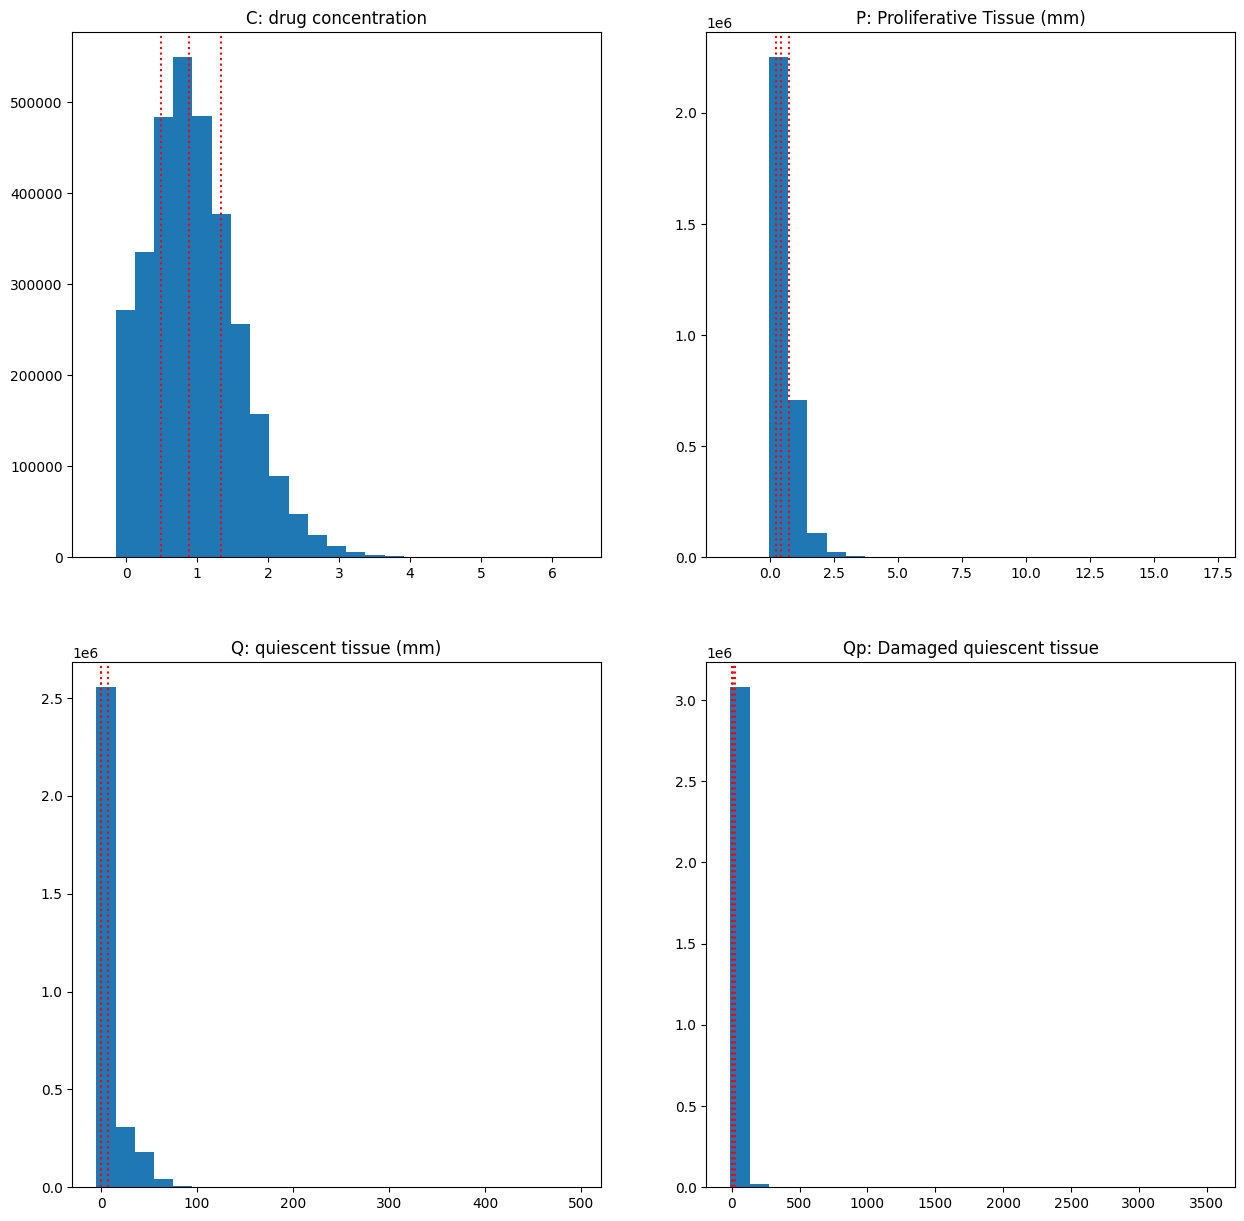

In [ ]:
fig,ax = plt.subplots(2,2,figsize=(15,15))
ax[0][0].hist(C_list,bins=25)
ax[0][0].set_title('C: drug concentration')
ax[0][0].axvline(C_25,color='r',linestyle = ":")
ax[0][0].axvline(C_50,color='r',linestyle = ":")
ax[0][0].axvline(C_75,color='r',linestyle = ":")

ax[0][1].hist(P_list,bins=25)
ax[0][1].set_title('P: Proliferative Tissue (mm)')
ax[0][1].axvline(P_25,color='r',linestyle = ":")
ax[0][1].axvline(P_50,color='r',linestyle = ":")
ax[0][1].axvline(P_75,color='r',linestyle = ":")

ax[1][0].hist(Q_list,bins=25)
ax[1][0].set_title('Q: quiescent tissue (mm)')
ax[1][0].axvline(Q_25,color='r',linestyle = ":")
ax[1][0].axvline(Q_50,color='r',linestyle = ":")
ax[1][0].axvline(Q_75,color='r',linestyle = ":")

ax[1][1].hist(Qp_list,bins=25)
ax[1][1].set_title('Qp: Damaged quiescent tissue')
ax[1][1].axvline(Qp_25,color='r',linestyle = ":")
ax[1][1].axvline(Qp_50,color='r',linestyle = ":")
ax[1][1].axvline(Qp_75,color='r',linestyle = ":")

In [ ]:
print(min(C_list))
print(max(C_list))

print(min(Q_list))
print(max(Q_list))

print(min(P_list))
print(max(P_list))

print(min(Qp_list))
print(max(Qp_list))

-0.41977313896331464
6.345657931975775
-4.863372601962225
495.37397688236285
-1.552854263573678
17.21502030222788
-8.99573565693143
3529.818815805774


## Helper function to discretize and convert from 4-d to 1-d state space

In [ ]:
def convert_state(s):
  """Convert cancer simulation state to 1-d discrete

  input is 4-d continuous state as defined in cancer simulator
  output is numerical tabular state

  """
  C,P,Q,Qp = s

  #first convert each dimension to quantile
  C_discrete = 0*(s[0]< C_25) + 1*((s[0] >= C_25) & (s[0] < C_50)) + 2*((s[0] >= C_50) & (s[0] < C_75)) + 3*(s[0]> C_75)
  P_discrete = 0*(s[1]< P_25) + 1*((s[1] >= P_25) & (s[1] < P_50)) + 2*((s[1] >= P_50) & (s[1] < P_75)) + 3*(s[1]> P_75)
  Q_discrete = 0*(s[2]< Q_25) + 1*((s[2] >= Q_25) & (s[2] < Q_50)) + 2*((s[2] >= Q_50) & (s[2] < Q_75)) + 3*(s[2]> Q_75)
  Qp_discrete = 0*(s[3]< Qp_25) + 1*((s[3] >= Qp_25) & (s[3] < Qp_50)) + 2*((s[3] >= Qp_50) & (s[3] < Qp_75)) + 3*(s[3]> Qp_75)
  s_4d_discrete = [C_discrete,P_discrete,Q_discrete,Qp_discrete]

  # then convert to 1D
  one_d_state = np.ravel_multi_index(tuple(s_4d_discrete),(4,4,4,4))
  return one_d_state

## Generate trajectory from one run of simulator

In [ ]:
def single_run(pct_treat = .1):
  csim = EnvCancer(dose_penalty = 10, transition_noise=.25)

  csim.reset()
  #initialize -- only saving off states so we can look at the distribution of each dimension to discretize
  state_list = []
  action_list = []
  reward_list = []

  state_list.append(convert_state(csim.state))

  max_steps = random.randint(0,csim.max_steps) #length of traj

  while csim.time_step < max_steps:

    #take action
    a = np.random.binomial(1,pct_treat)
    s_prime,r = csim.perform_action(a)

    #save data
    state_list.append(convert_state(s_prime))
    action_list.append(a)
    reward_list.append(r)

  return state_list,action_list,reward_list

## Helper functions to estimate MDP
data  = [[state_list,action_list,reward_list],[state_list,action_list,reward_list],...]

In [ ]:
def estimate_mdp(data):
  num_states = 4*4*4*4
  num_actions = 2
  T_counts = np.zeros((num_actions,num_states,num_states))
  R_sum = np.zeros((num_actions,num_states))

  T_default = (1./num_states)*np.ones(num_states)
  R_default = 0

  for d in data:

    #add transition data to count matrix
    state_list = d[0]
    action_list = d[1]
    reward_list = d[2]
    for i in range(len(state_list)-1):
      a = action_list[i]
      s = state_list[i]
      s_prime = state_list[i+1]
      T_counts[a][s][s_prime] +=1
      R_sum[a][s_prime] += reward_list[i]

  #estimate T and R
  T_hat = np.zeros((num_actions,num_states,num_states))
  r_hat = np.zeros((num_actions,num_states))

  for a in range(num_actions):
    for s in range(num_states):
      total_counts = np.sum(T_counts[a][s])
      if total_counts == 0:
        T_hat[a][s] = T_default
        r_hat[a][s] = R_default
      else:
        T_hat[a][s] = T_counts[a][s]/total_counts
        r_hat[a][s] = R_sum[a][s]/total_counts

  return T_hat,r_hat,T_counts


In [ ]:
#frequency of each state in "True" data set
def state_weights(data):
  num_states = 4*4*4*4
  state_count = np.zeros(num_states)

  for d in data:
    state_list = d[0]
    for s in state_list:
      state_count[s]+=1
  return state_count/float(sum(state_count))

## Estimate T, R for n runs of simulator


In [ ]:
def get_data_and_estimate(pct_treat,num_trajectories):
  data = []
  for n in range(num_trajectories):
    s,a,r = single_run(pct_treat)
    data.append([s,a,r])

  return estimate_mdp(data),state_weights(data)

# Define True MDP for below and also ground truth for simulations
[T_true,R_true,T_counts],true_weights = get_data_and_estimate(pct_treat = .50,num_trajectories = 100000)

## Dynamic Programming


In [ ]:
def value_iter(gamma, T_list,R_list, theta = .0001):
  """Value Iteration
  """
  num_states = T_list.shape[1]

  T = torch.tensor(np.array([np.array(x) for x in T_list]))
  R = torch.tensor(np.array(R_list))

  #V = torch.tensor(np.zeros(10))
  V = torch.tensor(np.random.uniform(0,1,num_states))
  delta = 10.

  while delta > theta:
      v = V
      V = torch.max(R + gamma*torch.einsum("bij,j->bi", T, V),dim=0).values
      delta= torch.max(torch.abs(v-V)).item()

  #get greedy policy
  P = torch.max(R + gamma*torch.einsum("bij,j->bi", T, V),dim=0).indices

  return np.array(P),np.array(V)


In [ ]:
def eval_policy(gamma,policy,T_list,R_list,theta):
  """Policy evaluation
  """
  num_states = T_list[0].shape[0]

  index = list(zip(policy,range(num_states)))
  T_pi = np.matrix([T_list[i][j] for (i,j) in index])
  #R_pi = np.transpose(np.matrix(R_list))
  R_pi = np.array([R_list[i][j] for (i,j) in index])

  value = np.linalg.solve(np.eye(num_states)-gamma*T_pi,R_pi)

  return value

## Regularization

### global param for all states

In [ ]:
def uniform_prior(eps,sa_count_list):
    T_unif_list = []
    num_actions = sa_count_list.shape[0]
    num_states = sa_count_list.shape[1]
    unif_prior = np.ones((num_states,num_states))

    total_sa_count = 0
    for sa_count in sa_count_list:
      total_sa_count += np.sum(sa_count)
    avg_count = total_sa_count/(num_states*num_actions)
    mag = eps/(1-eps)*avg_count/num_states

    for sa_count in sa_count_list:
        if eps == 1:
            alpha_post = 0*sa_count+unif_prior
        else:
            alpha_post = sa_count + mag*unif_prior

        T_post = np.zeros((num_states,num_states))
        default = (1./num_states)*np.ones(num_states) #uniform default, as above
        for i in range(num_states):
            sum_state = alpha_post[i].sum()
            if sum_state == 0: # never visited state i and took action "act"
                T_post[i] = default
            else:
                T_post[i] = (1./sum_state)*alpha_post[i]
        T_unif_list.append(T_post)

    return T_unif_list

### State-specific

In [ ]:
def epsilon_star_unif(T_sa,num_samples):
  """Calculate optimal value of epsilon for uniform prior

  Optimal epsilon if we knew true value of T

  """
  num_states = len(T_sa)
  numerator = 0
  denominator = 0
  for s_prime in range(num_states):
    numerator += (1./num_samples)*T_sa[s_prime]*(1-T_sa[s_prime])
    denominator += ((1./num_samples)*T_sa[s_prime]*(1-T_sa[s_prime]) + T_sa[s_prime]**2 - 2/num_states*T_sa[s_prime] + 1/(num_states**2))
  return numerator/denominator

def mse_unif(T_sa,epsilon,num_samples):
  mse = 0
  num_states = len(T_sa)
  for s_prime in range(num_states):
    mse += (1-epsilon)**2*(1/num_samples)*T_sa[s_prime]*(1-T_sa[s_prime])+epsilon**2*((1/num_states)-T_sa[s_prime])**2

  return mse

In [ ]:
def epsilon_star_hat_unif(sa_count_list):

  """Calculate optimal value of epsilon for uniform prior

  Optimal epsilon for single s-a pair for when we do not know true T

  """
  epsilon_list = np.linspace(0,1,100)
  num_resamples = 25
  prior_mag = .10

  max_mse_by_eps = []
  mean_mse_by_eps = []
  mse = 0
  num_samples = np.sum(sa_count_list)

  #define posterior. T_sa ~ dirichlet(alpha)
  alpha = tuple(x+prior_mag for x in sa_count_list)
  for e in epsilon_list:

    mse_list = []
    for n in range(num_resamples):

      #sample new T-hat from posterior
      T_samp = np.random.dirichlet(alpha)

      #calc MSE
      if num_samples > 0:
        mse = mse_unif(T_samp,e,num_samples)
      else:
        mse = mse_unif(T_samp,e,1)
      mse_list.append(mse)

    #max_mse_by_eps.append(max(mse_list))
    mean_mse_by_eps.append(np.mean(mse_list))

  #min_index = max_mse_by_eps.index(min(max_mse_by_eps))
  min_index = mean_mse_by_eps.index(min(mean_mse_by_eps))


  return epsilon_list[min_index]

In [ ]:
def T_reg_unif_per_state(T_mle_list,sa_count_list,cross_validate=False):

  num_states = T_mle_list[0].shape[0]
  num_actions = len(T_mle_list)
  T_reg_list = []
  T_unif = (1./num_states)*np.ones(num_states)

  T_sa_reg_list = [] #list of regularized transition matrixes for each action
  for a in range(num_actions):
    T_sa_reg = [] #action a regularized matrix
    num_samples_a = sa_count_list[a].sum(axis=1).tolist()
    for row_num in range(num_states):
      num_sa_samples = num_samples_a[row_num]
      if cross_validate==True:
        eps_sa = epsilon_star_hat_unif(sa_count_list[a].tolist()[row_num])
      else:
        try:
          eps_sa = epsilon_star_unif(T_mle_list[a].tolist()[row_num],num_sa_samples)
        except:
          eps_sa = 1

      T_sa_reg.append([(1-eps_sa)*x + eps_sa*y for (x,y) in zip(T_mle_list[a].tolist()[row_num],T_unif)])
    T_sa_reg_list.append(np.array(T_sa_reg))

  return T_sa_reg_list

In [ ]:
def T_reg_unif_per_state_trueT(T_list,T_mle_list,sa_count_list):

  """State-specific regularization calculating epsilon* using true T

  (Theoretical minimum loss using our method)

  """
  num_states = T_list[0].shape[0]
  num_actions = len(T_list)
  T_reg_list = []
  T_unif = (1./num_states)*np.ones(num_states)

  T_sa_reg_list = [] #list of regularized transition matrixes for each action
  for a in range(num_actions):
    T_sa_reg = [] #action a regularized matrix
    num_samples_a = sa_count_list[a].sum(axis=1).tolist()
    for row_num in range(num_states):
      num_sa_samples = num_samples_a[row_num]
      if num_sa_samples > 0:
        eps_sa = epsilon_star_unif(T_list[a][row_num],num_sa_samples)
      else:
        eps_sa = 1
      #print('num_sa_samples',num_sa_samples)
      #print('epsilon',eps_sa)
      T_sa_reg.append([(1-eps_sa)*x + eps_sa*y for (x,y) in zip(T_mle_list[a][row_num],T_unif)])
    T_sa_reg_list.append(np.array(T_sa_reg))

  return T_sa_reg_list

## Compare Loss by Regularization Method

In [ ]:
def calc_loss(num_trajectories,num_datasets,T_true,R_true):

  gamma_eval = 0.99
  theta = .0001
  epsilon_list = [0,.1,.2,.3,.4,.5,.6,.7,.8,.9,.95,.99]
  pct_treat = .50

  #store loss for each value of epsilon
  loss_dict_disc = {} #discount regularization
  loss_dict_unif = {} #uniform prior with equal magnitude
  for e in epsilon_list:
    loss_dict_disc[e] = []
    loss_dict_unif[e] = []

  #loss for state-specfic
  loss_list_unif_ss_cv = [] #state specific with epsilon found by cv
  loss_list_unif_ss_MLE = [] #state specific with epsilon found using t-mle
  loss_list_unif_ss_TrueT = [] #state specific with epsilon found using true T

  # True MDP, policy, value
  #T_true,R_true,T_counts_true = get_data_and_estimate(1000)  #move this outside as global variable if running multiple times
  p,v = value_iter(gamma_eval,T_true,R_true,theta)
  num_states = T_true.shape[1]
  start_state_weights = (1./num_states)*np.ones(num_states) #evalulation

  for n in range(num_datasets):
    print('n',n)
    [T_mle,R_mle,T_counts],w = get_data_and_estimate(pct_treat,num_trajectories)
    #print('T_counts',T_counts.sum(axis=1))

    #state specific epsilon losses - unif WITH CV
    T_unif_ss_list = T_reg_unif_per_state(T_mle,T_counts,cross_validate=True)
    p_unif_ss,v_unif_ss = value_iter(gamma_eval,np.array(T_unif_ss_list),R_true)
    v_unif_ss = eval_policy(gamma_eval,np.array(p_unif_ss),T_true,R_true,theta) #calculate value of policy in true MDP
    loss_unif_ss = v - np.array(v_unif_ss)
    loss_unif_ss = np.average(loss_unif_ss,axis=None,weights=true_weights)
    loss_list_unif_ss_cv.append(loss_unif_ss)
    print('loss_unif_ss',loss_unif_ss)

    #state specific - Using true T to get theoretical min loss
    T_unif_ss_list2 = T_reg_unif_per_state_trueT(T_true,T_mle,T_counts)
    p_unif_ss2,v_unif_ss2 = value_iter(gamma_eval,np.array(T_unif_ss_list2),R_true)
    v_unif_ss2 = eval_policy(gamma_eval,np.array(p_unif_ss2),T_true,R_true,theta) #calculate value of policy in true MDP
    loss_unif_ss2 = v - np.array(v_unif_ss2)
    loss_unif_ss2 = np.average(loss_unif_ss2,axis=None,weights=true_weights)
    loss_list_unif_ss_TrueT.append(loss_unif_ss2)
    print('loss_unif_ss2',loss_unif_ss2)

    #state specific epsilon losses - unif WITHOUT CV
    T_unif_ss_list3 = T_reg_unif_per_state(T_mle,T_counts,cross_validate=False)
    p_unif_ss3,v_unif_ss3 = value_iter(gamma_eval,np.array(T_unif_ss_list3),R_true)
    v_unif_ss3 = eval_policy(gamma_eval,np.array(p_unif_ss3),T_true,R_true,theta) #calculate value of policy in true MDP
    loss_unif_ss3 = v - np.array(v_unif_ss3)
    loss_unif_ss3 = np.average(loss_unif_ss3,axis=None,weights=true_weights)
    loss_list_unif_ss_MLE.append(loss_unif_ss3)

    for e in epsilon_list:
      T_hat_unif = uniform_prior(e,T_counts)

      #calculate optimal policy and its value for regularized MDPs
      #assume R known
      p_disc,v_disc = value_iter((1-e)*gamma_eval,T_mle,R_true,theta)
      p_unif,v_unif = value_iter(gamma_eval,np.array(T_hat_unif),R_true,theta)

      #calculate value of policies above using true MDP
      v_disc = eval_policy(gamma_eval,p_disc,T_true,R_true,theta)
      v_unif = eval_policy(gamma_eval,p_unif,T_true,R_true,theta)

      #loss = expected value over starting state distrib
      loss_disc = v - np.array(v_disc)
      loss_unif = v - np.array(v_unif)

      loss_dict_disc[e].append(np.average(loss_disc,axis=None,weights=true_weights))
      loss_dict_unif[e].append(np.average(loss_unif,axis=None,weights=true_weights))

    #mean loss
    mean_loss_disc = []
    mean_loss_unif = []
    for e in epsilon_list:
        mean_loss_disc.append(np.mean(loss_dict_disc[e]))
        mean_loss_unif.append(np.mean(loss_dict_unif[e]))

    #stdev loss of MEAN loss
    stdev_loss_disc = []
    stdev_loss_unif = []
    for e in epsilon_list:
        stdev_loss_disc.append(np.std(loss_dict_disc[e])/np.sqrt(num_datasets))
        stdev_loss_unif.append(np.std(loss_dict_unif[e])/np.sqrt(num_datasets))

  return mean_loss_disc,mean_loss_unif,stdev_loss_disc,stdev_loss_unif,np.mean(loss_list_unif_ss_cv),np.mean(loss_list_unif_ss_TrueT),np.mean(loss_list_unif_ss_MLE),np.std(loss_list_unif_ss_cv)/np.sqrt(num_datasets),np.std(loss_list_unif_ss_MLE)/np.sqrt(num_datasets)


n 0
loss_unif_ss 253.20510466712636
loss_unif_ss2 248.37923833546142
n 1
loss_unif_ss 248.37923833546142
loss_unif_ss2 244.54911639707743
n 2
loss_unif_ss 252.56485658661452
loss_unif_ss2 251.97374380839986
n 3
loss_unif_ss 248.37923833546142
loss_unif_ss2 246.38845807937886
n 4
loss_unif_ss 248.99174804000455
loss_unif_ss2 250.9239331010959
n 5
loss_unif_ss 248.37923833546142
loss_unif_ss2 245.13634616037106
n 6
loss_unif_ss 248.99174804000455
loss_unif_ss2 245.99777922049785
n 7
loss_unif_ss 248.37923833546142
loss_unif_ss2 244.51160420820315
n 8
loss_unif_ss 253.20510466712636
loss_unif_ss2 245.56760417873807
n 9
loss_unif_ss 253.20510466712636
loss_unif_ss2 244.54078828814755
n 10
loss_unif_ss 253.20510466712636
loss_unif_ss2 243.64530237004948
n 11
loss_unif_ss 248.37923833546142
loss_unif_ss2 245.20574325710453
n 12
loss_unif_ss 248.37923833546142
loss_unif_ss2 253.8796706217019
n 13
loss_unif_ss 248.37923833546142
loss_unif_ss2 243.9357655653558
n 14
loss_unif_ss 254.07662427417

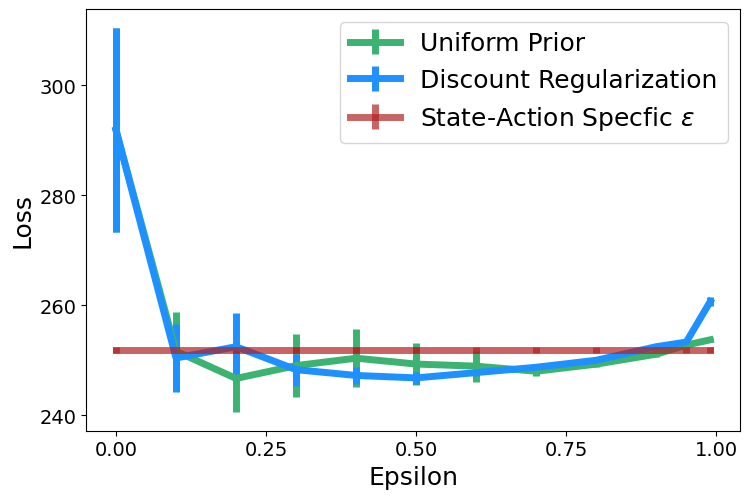

In [ ]:
#.25 transition noise
# dose_penalty = 10
# start state: .1 transition_noise
# length: random lengths to increase uneven distrib of data
# 50 traj
# 50% treat
# 500 resamples

num_traj = 50
num_datasets = 100
mean_loss_disc, mean_loss_unif,stdev_loss_disc,stdev_loss_unif,loss_unif_ss_cv,loss_list_unif_ss_trueT,loss_unif_ss_mle,stdev_loss_ss_cv,stdev_loss_ss_mle=calc_loss(num_traj,num_datasets,T_true,R_true)
epsilon_list = [0,.1,.2,.3,.4,.5,.6,.7,.8,.9,.95,.99]

fig,ax = plt.subplots(1,1,figsize=(8,6))
#ax.plot(epsilon_list,eg_normalized,label = 'Epsilon-Greedy',alpha=.5,linewidth = 5.0,color='mediumseagreen')
#ax.plot(epsilon_list,mean_loss_unif,label = 'Uniform Prior',alpha=.8,linewidth = 5.0,color='#3a98c7')
ax.errorbar(epsilon_list, mean_loss_unif, yerr=[2*j for j in stdev_loss_unif],label = 'Uniform Prior',linewidth =5.0,color='mediumseagreen')
#ax.plot(epsilon_list,mean_loss_disc,label = 'Discount Regularization',alpha=.8,linewidth = 5.0,color='#ed6a47')
ax.errorbar(epsilon_list, mean_loss_disc, yerr=[2*j for j in stdev_loss_disc],label = 'Discount Regularization',linewidth = 5.0,color='dodgerblue')
#ax.axhline(y=loss_unif_ss_cv, color='darkblue', linestyle='-',linewidth = 5.0,alpha = .7, label = r"State-action specfic $\epsilon$ (CV)")
ax.errorbar(epsilon_list,[loss_unif_ss_cv for i in epsilon_list],yerr=[2*stdev_loss_ss_cv for j in epsilon_list],color='firebrick',linewidth = 5.0,alpha = .7,label = r"State-Action Specfic $\epsilon$")
#ax.axhline(y=loss_unif_ss_mle, color='teal', linestyle='-',linewidth = 5.0,alpha = .7, label = r"State-action specfic $\epsilon$ (MLE)")
#ax.errorbar(epsilon_list,[loss_unif_ss_mle for i in epsilon_list],yerr=[2*stdev_loss_ss_mle for j in epsilon_list],color='teal',linewidth = 5.0,alpha = .7,label = r"State-action specfic $\epsilon$ (MLE)")

ax.set_xlabel("Epsilon",fontsize=18)
ax.set_ylabel("Loss",fontsize=18)
ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(5))
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=16)

ax.legend(fontsize=18)

fig.tight_layout(rect=[0.05, 0, 1, 0.85])
plt.savefig('/content/gdrive/My Drive/cancer.pdf')